#AON - INTERVIEW Python Notebook for the analysis & prediction of 'Relative CPU Performance Data'

In [75]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')
import os

In [76]:
import numpy as np
import pandas as pd

In [77]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV

In [78]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

In [79]:
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

#Setup helper functions

def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map(df):
    corr = data.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )


def describe_more(df):
    var = [];
    l = [];
    t = []
    for x in df:
        var.append(x)
        l.append(len(pd.value_counts(df[x])))
        t.append(df[x].dtypes)
    levels = pd.DataFrame({'Variable': var, 'Levels': l, 'Datatype': t})
    levels.sort_values(by='Levels', inplace=True)
    return levels


def plot_variable_importance(X, y):
    tree = DecisionTreeClassifier(random_state=99)
    tree.fit(X, y)
    plot_model_var_imp(tree, X, y)


def plot_model_var_imp(model, X, y):
    imp = pd.DataFrame(
        model.feature_importances_,
        columns=['Importance'],
        index=X.columns
    )
    imp = imp.sort_values(['Importance'], ascending=True)
    imp[: 10].plot(kind='barh')
    print(model.score(X, y))

In [80]:
os.curdir #gives us the current directory
os.listdir() #Lists all the files in teh current directory
names = ['VENDOR','MODEL_NAME','MYCT', 'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX', 'PRP', 'ERP'] #Since our data has no lables we are creating a df with lables and will be later added to the Data
data = pd.read_csv('/Users/Balaji/PycharmProjects/Aon Project/data/machine.data', names= names)
data = pd.DataFrame(data)

In [81]:
pd.set_option('display.expand_frame_repr', False) # to display max cols & rows

In [82]:
data.head() #shows the first five rows
data.tail() #shows last five rows

,VENDOR,MODEL_NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47
208,wang,vs-90,480,1000,4000,0,0,0,45,25


In [83]:
data.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,105.622010,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,160.830733,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,113.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000,1238.000000


In [84]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 10 columns):
VENDOR        209 non-null object
MODEL_NAME    209 non-null object
MYCT          209 non-null int64
MMIN          209 non-null int64
MMAX          209 non-null int64
CACH          209 non-null int64
CHMIN         209 non-null int64
CHMAX         209 non-null int64
PRP           209 non-null int64
ERP           209 non-null int64
dtypes: int64(8), object(2)
memory usage: 16.4+ KB


In [85]:
#Copying ERP colum into a seperate dataframe
data_ERP =  data[data.columns[-1]]
data_ERP.head()
#Dropping ERP column
data=data.drop('ERP',axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 9 columns):
VENDOR        209 non-null object
MODEL_NAME    209 non-null object
MYCT          209 non-null int64
MMIN          209 non-null int64
MMAX          209 non-null int64
CACH          209 non-null int64
CHMIN         209 non-null int64
CHMAX         209 non-null int64
PRP           209 non-null int64
dtypes: int64(7), object(2)
memory usage: 14.8+ KB


In [86]:
data.corr() #Correlation matrix to see the tentative dependencies between columns

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
MYCT,1.000000,-0.335642,-0.378561,-0.321000,-0.301090,-0.250502,-0.307099
MMIN,-0.335642,1.000000,0.758157,0.534729,0.517189,0.266907,0.794931
MMAX,-0.378561,0.758157,1.000000,0.537990,0.560513,0.527246,0.863004
CACH,-0.321000,0.534729,0.537990,1.000000,0.582245,0.487846,0.662641
CHMIN,-0.301090,0.517189,0.560513,0.582245,1.000000,0.548281,0.608903
CHMAX,-0.250502,0.266907,0.527246,0.487846,0.548281,1.000000,0.605209
PRP,-0.307099,0.794931,0.863004,0.662641,0.608903,0.605209,1.000000


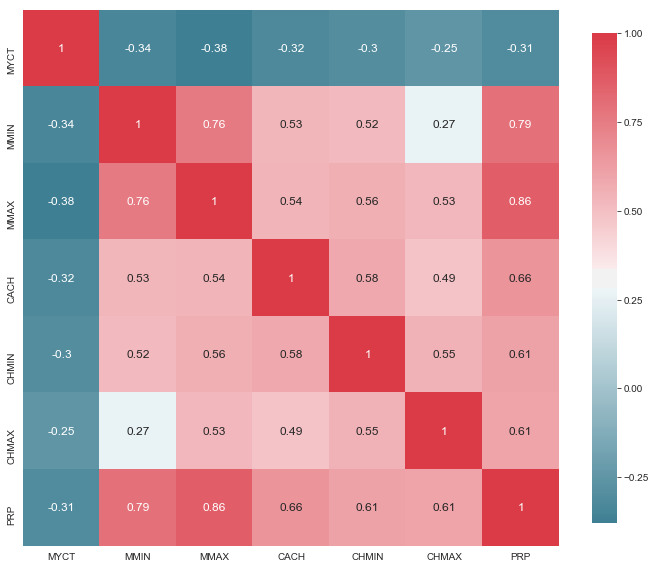

In [87]:
plot_correlation_map(data)

In [95]:
data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']].skew()

MYCT     2.544153
MMIN     3.515933
MMAX     2.140663
CACH     2.824777
CHMIN    4.027333
CHMAX    3.595905
PRP      3.892814
dtype: float64

In [ ]:
#EDA
data['VENDOR'].value_counts().sort_values(ascending=False)
data.groupby('VENDOR')['MODEL_NAME'].nunique().sort_values(ascending=False)
(data.groupby('VENDOR')['PRP'].mean()).sort_values(ascending=False)

In [125]:
(data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']]).apply(lambda column: (column<= 0).sum())

MYCT      0
MMIN      0
MMAX      0
CACH     69
CHMIN     5
CHMAX     5
PRP       0
dtype: int64

In [129]:
data['CACH'] = data['CACH']+1
data['CHMIN'] = data['CHMIN']+1
data['CHMAX'] = data['CHMAX'] +1

In [130]:
(data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']]).apply(lambda column: (column<= 0).sum())

MYCT     0
MMIN     0
MMAX     0
CACH     0
CHMIN    0
CHMAX    0
PRP      0
dtype: int64

In [131]:
data_log = np.log(data[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']])

In [132]:
data_log.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,4.828314,5.545177,8.699515,5.552960,2.833213,4.859812,5.288267
1,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508,5.594711
2,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508,5.393628
3,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508,5.147494
4,3.367296,8.987197,9.680344,3.526361,2.197225,2.833213,4.882802


In [134]:
data_log[['MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP']].skew() #Checking skewness for the data_log

MYCT     0.397838
MMIN     0.036612
MMAX    -0.617669
CACH     0.232088
CHMIN    0.802618
CHMAX    0.136018
PRP      0.521715
dtype: float64

In [158]:
data_transformed = pd.concat([data[['VENDOR','MODEL_NAME']],data_log], axis=1, ignore_index=False) #Combaining data_log dataframe & 'VENDOR','MODEL_NAME' columns from data
data_transformed.head()

,VENDOR,MODEL_NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
0,adviser,32/60,4.828314,5.545177,8.699515,5.552960,2.833213,4.859812,5.288267
1,amdahl,470v/7,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508,5.594711
2,amdahl,470v/7a,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508,5.393628
3,amdahl,470v/7b,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508,5.147494
4,amdahl,470v/7c,3.367296,8.987197,9.680344,3.526361,2.197225,2.833213,4.882802


In [152]:
print("mean : ", np.mean(data_transformed[data_transformed.columns[2:]]))
print("var  : ", np.var(data_transformed[data_transformed.columns[2:]]))
print("skew : ",skew(data_transformed[data_transformed.columns[2:]]))
print("kurt : ",kurtosis(data_transformed[data_transformed.columns[2:]]))

mean :  MYCT     4.746955
MMIN     7.360234
MMAX     8.922222
CACH     2.352106
CHMIN    1.355234
CHMAX    2.407778
PRP      4.037242
dtype: float64
var  :  MYCT     1.072055
MMIN     1.212674
MMAX     1.060236
CACH     2.045868
CHMIN    0.645803
CHMAX    1.068150
PRP      1.093810
dtype: float64
skew :  [ 0.39497709  0.03634833 -0.61322713  0.23041925  0.7968465   0.13504012
  0.51796328]
kurt :  [-0.55809672 -0.11664283  1.42352435 -1.19766335 -0.03340823 -0.08047523
 -0.06268279]


In [161]:
data_transformed.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,4.746955,7.360234,8.922222,2.352106,1.355234,2.407778,4.037242
std,1.037887,1.103859,1.032150,1.433773,0.805548,1.035995,1.048365
min,2.833213,4.158883,4.158883,0.693147,0.000000,0.000000,1.791759
25%,3.912023,6.643790,8.294050,0.693147,0.693147,1.791759,3.295837
50%,4.700480,7.600902,8.987197,2.302585,1.098612,2.197225,3.912023
75%,5.416100,8.294050,9.680344,3.526361,1.945910,3.218876,4.727388
max,7.313220,10.373491,11.066638,5.552960,3.970292,5.176150,7.047517


In [231]:

df = data_transformed[data_transformed.columns[0:8]]
y = data_transformed[data_transformed.columns[-1:]]

In [268]:
# One-hot encode the data using pandas get_dummies
features = pd.get_dummies(df)

In [205]:
# Labels are the values we want to predict
labels = np.array(y)

In [218]:
# Remove the labels from the features
# axis 1 refers to the columns
features= features

# Saving feature names for later use
feature_list = list(features)
# Convert to numpy array
features = np.array(features)


In [219]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [220]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (156, 245)
Training Labels Shape: (156, 1)
Testing Features Shape: (53, 245)
Testing Labels Shape: (53, 1)


In [226]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [227]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 1.26 degrees.


In [228]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 67.69 %.


#Trying linear regression model

In [262]:
df.head()
#y.head()

,VENDOR,MODEL_NAME,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,adviser,32/60,4.828314,5.545177,8.699515,5.552960,2.833213,4.859812
1,amdahl,470v/7,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508
2,amdahl,470v/7a,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508
3,amdahl,470v/7b,3.367296,8.987197,10.373491,3.526361,2.197225,3.496508
4,amdahl,470v/7c,3.367296,8.987197,9.680344,3.526361,2.197225,2.833213


In [273]:
Vendor_dummy = pd.get_dummies(df, prefix= 'VENDOR')

In [274]:
Model_Name_dummy = pd.get_dummies( data.MODEL_NAME , prefix='MODEL_NAME' )

In [276]:
full_data = pd.concat( [ Vendor_dummy , Model_Name_dummy,df ] , axis=1 )

In [277]:
full_data.info
full_data = full_data.drop(columns=['VENDOR', 'MODEL_NAME'])

In [278]:
X_train, X_test, y_train, y_test = train_test_split(full_data, y, test_size=0.2)
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(167, 460) (167, 1)
(42, 460) (42, 1)


In [279]:
from sklearn import linear_model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


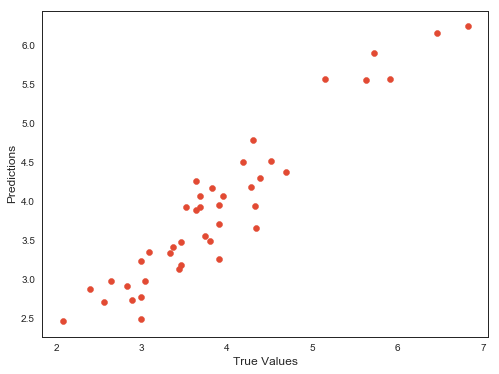

Score: 0.901317093405053


In [280]:
## The line / model
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.show()

print ('Score:', model.score(X_test, y_test))


Cross-validated scores: [0.64626101 0.72142865 0.85385032 0.42274413 0.80766049 0.82159345]


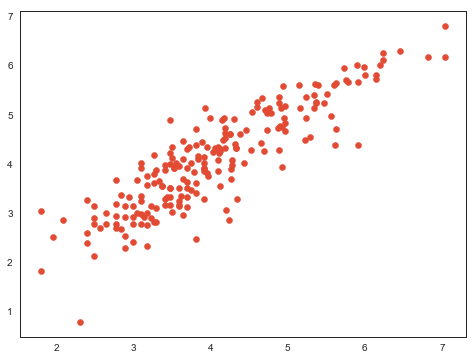

Cross-Predicted Accuracy: 0.7715515739614602


In [281]:
#Cross Validation
from sklearn.model_selection import KFold # import KFold

# Necessary imports:
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

# Perform 6-fold cross validation
scores = cross_val_score(model, full_data, y, cv=6)
print ('Cross-validated scores:', scores)

# Make cross validated predictions
predictions = cross_val_predict(model, full_data, y, cv=6)
plt.scatter(y, predictions)
plt.show()


accuracy = metrics.r2_score(y, predictions)
print ('Cross-Predicted Accuracy:', accuracy)

